In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import model_from_json
from tensorflow.keras import backend as K
import pandas as pd

In [3]:
# Function to load and preprocess images
def load_and_preprocess_images(folder_path, subfolders, image_size=(224, 224)):
    label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}
    images, labels = [], []
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, image_size)
                images.append(img_resized)
                labels.append(label_map[subfolder])
    images = np.array(images).astype('float32') / 255.0
    labels = np.array(labels)
    return images, labels

In [4]:
# Paths and categories
train_path = "C:/Users/vinay/Projects/Anoop/second/archive/Fruits Classification/train"
test_path = "C:/Users/vinay/Projects/Anoop/second/archive/Fruits Classification/test"
subfolders = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']

# Load data
x_train, y_train = load_and_preprocess_images(train_path, subfolders)
x_test, y_test = load_and_preprocess_images(test_path, subfolders)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(subfolders))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(subfolders))

# Split train data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [5]:
# Define three architectures: ResNet-18, AlexNet, and MobileNet
def build_resnet18(learning_rate=0.0001, dropout_rate=0.5):
    base_model = tf.keras.applications.ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(len(subfolders), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_alexnet(learning_rate=0.0001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((3, 3), strides=2),
        layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D((3, 3), strides=2),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((3, 3), strides=2),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(len(subfolders), activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_mobilenet(learning_rate=0.0001):
    base_model = tf.keras.applications.MobileNet(weights=None, include_top=False, input_shape=(224, 224, 3))
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(len(subfolders), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [52]:
# List of models to compare
models_to_train = {
    'AlexNet': build_alexnet(),
    'MobileNet': build_mobilenet(),
    'ResNet_18': build_resnet18()
}

# Callback for early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

C:\Users\vinay\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
# Function to train each model and store results
history_dict = {}
for model_name, model in models_to_train.items():
    model_file = f"{model_name}_model.weights.h5"
    model_json_file = f"{model_name}_model.json"

    # Check if the model is already saved
    if os.path.exists(model_file):
        print(f"Loading {model_name} model from file...")
        # Load the model architecture
        with open(model_json_file, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json)
        # Load the weights
        model.load_weights(model_file)

        # At this point, we don't need to train the model again, but if you want to retrain it, uncomment this block:
        # print(f"Retraining {model_name} model...")
        # history = model.fit(
        #     datagen.flow(x_train, y_train, batch_size=16),
        #     validation_data=(x_valid, y_valid),
        #     epochs=7,
        #     callbacks=[early_stop],
        #     verbose=1
        # )
        # history_dict[model_name] = history
    else:
        print(f"Training {model_name} model...")
        history = model.fit(
            datagen.flow(x_train, y_train, batch_size=16),
            validation_data=(x_valid, y_valid),
            epochs=7,
            callbacks=[early_stop],
            verbose=1
        )
        history_dict[model_name] = history  # Store the history here

        # Save model architecture and weights
        model_json = model.to_json()
        with open(model_json_file, "w") as json_file:
            json_file.write(model_json)
        model.save_weights(model_file)

    # Save the training history to a CSV file
    history_data = {
        'train_accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }
    history_df = pd.DataFrame(history_data)
    history_df.to_csv(f'{model_name}_history.csv', index=False)

    # Save confusion matrix and classification report
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    classification_rep = classification_report(y_true, y_pred, target_names=subfolders)

    with open(f"{model_name}_classification_report.txt", 'w') as f:
        f.write(classification_rep)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=subfolders, yticklabels=subfolders)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.close()

    # Clear the session to avoid memory issues after training
    K.clear_session()

Loading AlexNet model from file...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
Loading MobileNet model from file...
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step
Loading ResNet_18 model from file...
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [70]:
# Plotting accuracy and loss curves for each model
print(history_data)
plt.figure(figsize=(14, 10))
for model_name, history in history_dict.items():
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

{'train_accuracy': [0.43917524814605713, 0.5328608155250549, 0.5560566782951355, 0.5784794092178345, 0.6030927896499634, 0.6319587826728821, 0.6399484276771545], 'val_accuracy': [0.5376288890838623, 0.5561855435371399, 0.5932989716529846, 0.6159793734550476, 0.638144314289093, 0.6530928015708923, 0.6804123520851135], 'train_loss': [1.2838480472564697, 1.118576169013977, 1.0587078332901, 1.0135750770568848, 0.9692959189414978, 0.9191761016845703, 0.9010429978370667], 'val_loss': [1.096872329711914, 1.1031101942062378, 1.010343074798584, 0.9507169723510742, 0.908681333065033, 0.879387378692627, 0.8355614542961121]}


<Figure size 1400x1000 with 0 Axes>

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  
Loaded and evaluated ResNet_18.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
Loaded and evaluated AlexNet.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step
Loaded and evaluated MobileNet.


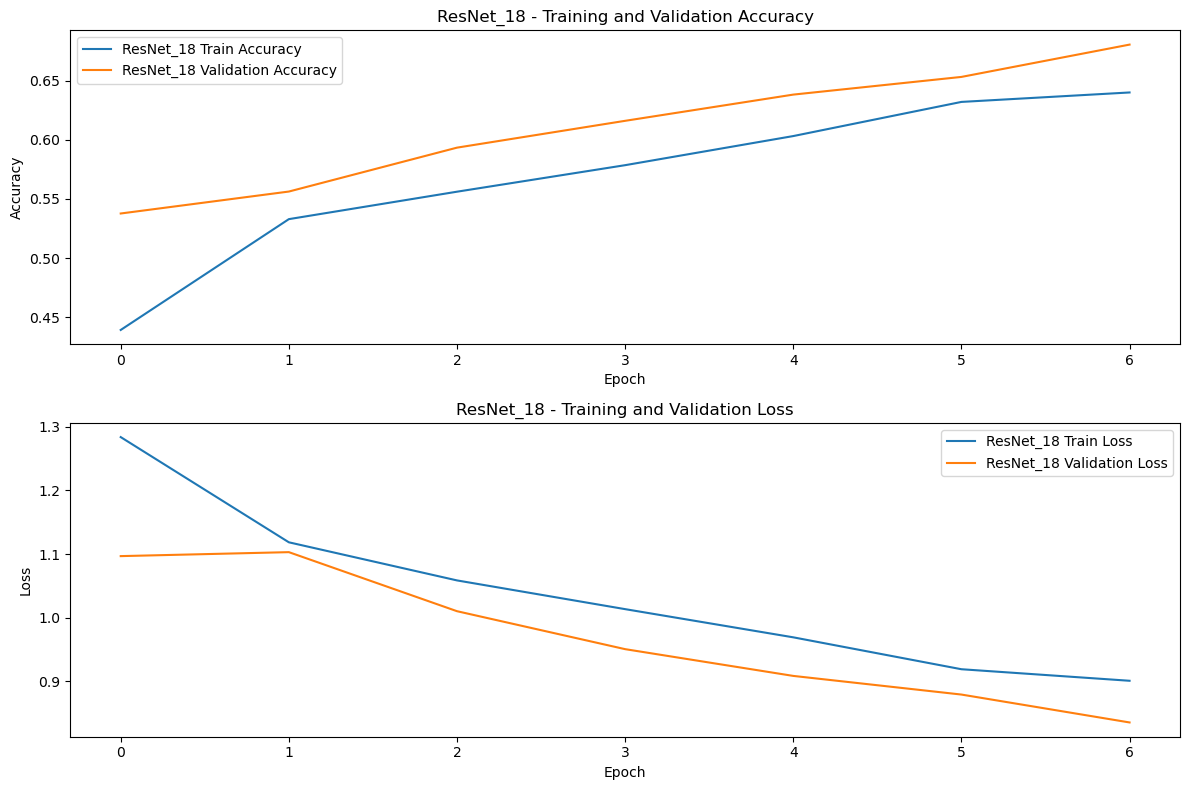

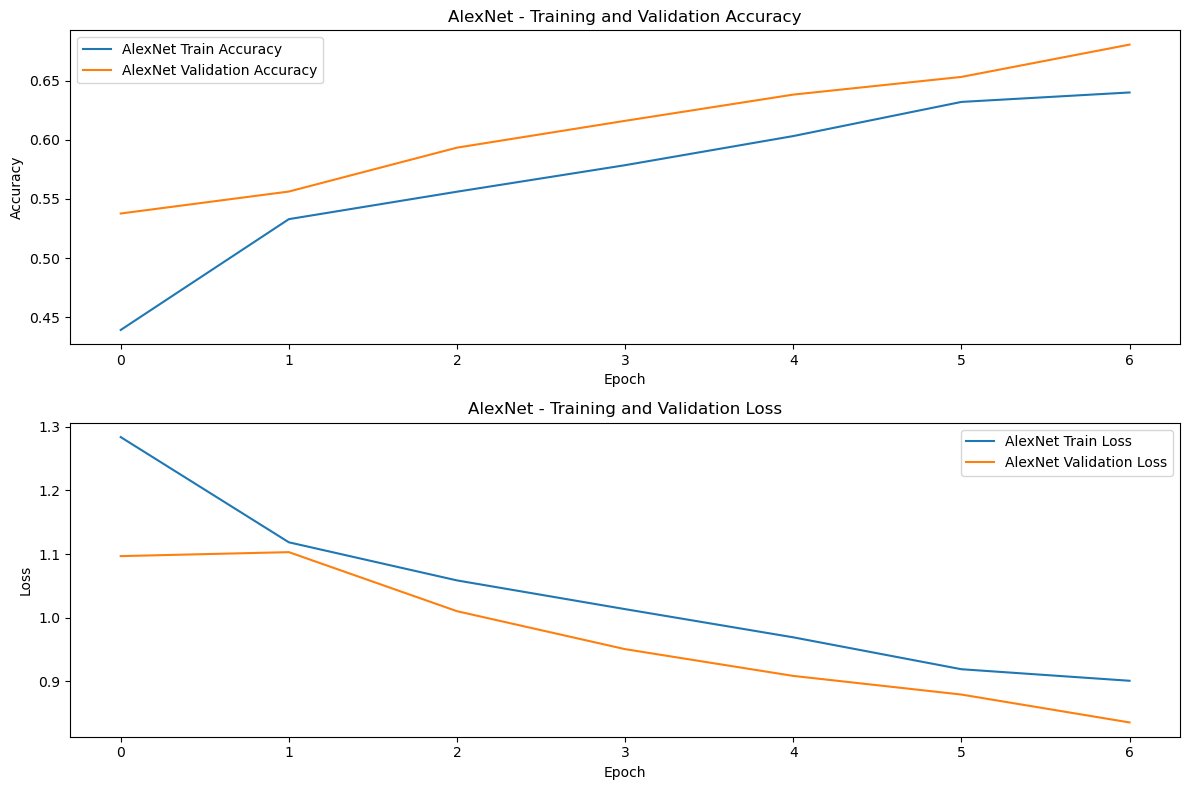

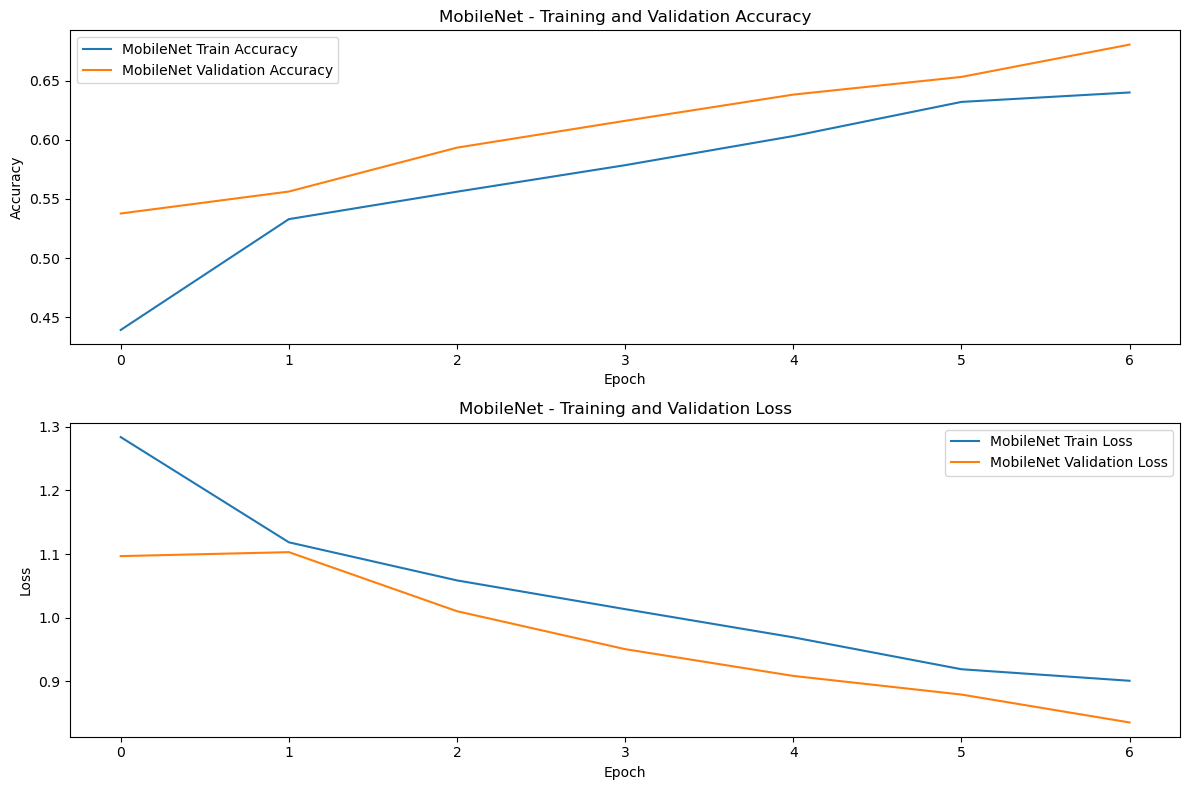

In [78]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import model_from_json
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Paths to the saved model files and history files
models_dir = './'  # Modify this if your models are saved in a different directory
history_dir = './'  # Modify if your history files are saved elsewhere
subfolders = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']

# List of model names
model_names = ['ResNet_18', 'AlexNet', 'MobileNet']

# Initialize history dictionary
history_dict = {}

# Load models and their histories
for model_name in model_names:
    model_json_file = os.path.join(models_dir, f"{model_name}_model.json")
    model_weights_file = os.path.join(models_dir, f"{model_name}_model.weights.h5")
    history_file = os.path.join(history_dir, f"{model_name}_history.csv")
    
    # Load the model architecture from JSON
    with open(model_json_file, 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)
    
    # Load the model weights
    model.load_weights(model_weights_file)

    # Load the training history from CSV file
    history_df = pd.read_csv(history_file)
    history_dict[model_name] = history_df

    # Make predictions and print the classification report
    y_pred = np.argmax(model.predict(x_test), axis=1)  # Assuming x_test is available
    y_true = np.argmax(y_test, axis=1)  # Assuming y_test is available

    # Classification report
    classification_rep = classification_report(y_true, y_pred, target_names=subfolders)
    with open(f"{model_name}_classification_report.txt", 'w') as f:
        f.write(classification_rep)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=subfolders, yticklabels=subfolders)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.close()

    print(f"Loaded and evaluated {model_name}.")

# Now plot the accuracy and loss curves for each model
for model_name, history_df in history_dict.items():
    # Create a new figure for each model
    plt.figure(figsize=(12, 8))

    # Plot Training and Validation Accuracy
    plt.subplot(2, 1, 1)
    plt.plot(history_df['train_accuracy'], label=f'{model_name} Train Accuracy')
    plt.plot(history_df['val_accuracy'], label=f'{model_name} Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(2, 1, 2)
    plt.plot(history_df['train_loss'], label=f'{model_name} Train Loss')
    plt.plot(history_df['val_loss'], label=f'{model_name} Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plot for the current model
    plt.tight_layout()
    plt.show()

